# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [2]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import pandas as pd
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorcName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

category                                           filePath  \
0   Kennedy  ../data/grimmerPressReleases\Kennedy\01Apr2005...   
10  Kennedy  ../data/grimmerPressReleases\Kennedy\01Dec2005...   
20  Kennedy  ../data/grimmerPressReleases\Kennedy\01Feb2006...   
30  Kennedy  ../data/grimmerPressReleases\Kennedy\01Feb2007...   
40  Kennedy  ../data/grimmerPressReleases\Kennedy\01Jun2007...   
50  Kennedy  ../data/grimmerPressReleases\Kennedy\01Mar2007...   
60  Kennedy  ../data/grimmerPressReleases\Kennedy\01May2007...   
70  Kennedy  ../data/grimmerPressReleases\Kennedy\01Nov2007...   
80  Kennedy  ../data/grimmerPressReleases\Kennedy\02Aug2006...   
90  Kennedy  ../data/grimmerPressReleases\Kennedy\02Feb2005...   

                                                 text  
0            FOR IMMEDIATE RELEASE   FOR IMMEDIATE...  
10           FOR IMMEDIATE RELEASE     Washington ...  
20           FOR IMMEDIATE RELEASE      Fact sheet...  
30           FOR IMMEDIATE RELEASE     Washington ...  
40           FOR IMMEDIATE RELEASE  BOSTON  MA  Se...  
50           FOR IMMEDIATE RELEASE     Washington ...  
60           FOR IMMEDIATE RELEASE  The President ...  
70           FOR IMMEDIATE RELEASE  Washington  DC...  
80           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...  
90           FOR IMMEDIATE RELEASE     The Preside...

Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [6]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

category                                           filePath  \
0   Kennedy  ../data/grimmerPressReleases\Kennedy\01Apr2005...   
10  Kennedy  ../data/grimmerPressReleases\Kennedy\01Dec2005...   
20  Kennedy  ../data/grimmerPressReleases\Kennedy\01Feb2006...   
30  Kennedy  ../data/grimmerPressReleases\Kennedy\01Feb2007...   
40  Kennedy  ../data/grimmerPressReleases\Kennedy\01Jun2007...   
50  Kennedy  ../data/grimmerPressReleases\Kennedy\01Mar2007...   
60  Kennedy  ../data/grimmerPressReleases\Kennedy\01May2007...   
70  Kennedy  ../data/grimmerPressReleases\Kennedy\01Nov2007...   
80  Kennedy  ../data/grimmerPressReleases\Kennedy\02Aug2006...   
90  Kennedy  ../data/grimmerPressReleases\Kennedy\02Feb2005...   

                                                 text  \
0            FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
10           FOR IMMEDIATE RELEASE     Washington ...   
20           FOR IMMEDIATE RELEASE      Fact sheet...   
30           FOR IMMEDIATE RELEASE     Washington ...   
40           FOR IMMEDIATE RELEASE  BOSTON  MA  Se...   
50           FOR IMMEDIATE RELEASE     Washington ...   
60           FOR IMMEDIATE RELEASE  The President ...   
70           FOR IMMEDIATE RELEASE  Washington  DC...   
80           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
90           FOR IMMEDIATE RELEASE     The Preside...   

                                      tokenized_sents  \
0   [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
10  [[FOR, IMMEDIATE, RELEASE, Washington], [D, C]...   
20  [[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...   
30  [[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...   
40  [[FOR, IMMEDIATE, RELEASE, BOSTON], [MA, Senat...   
50  [[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...   
60  [[FOR, IMMEDIATE, RELEASE], [The, President, i...   
70  [[FOR, IMMEDIATE, RELEASE, Washington], [DC, S...   
80  [[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...   
90  [[FOR, IMMEDIATE, RELEASE], [The, President, g...   

                                     normalized_sents  
0   [[immediate, release, immediate, release, cont...  
10  [[immediate, release, washington], [have, c], ...  
20  [[immediate, release, fact, sheet, bush, s, pl...  
30  [[immediate, release, washington, have, c, tod...  
40  [[immediate, release, boston], [ma, senator, e...  
50  [[immediate, release, washington, dc, today], ...  
60  [[immediate, release], [president, wrong, veto...  
70  [[immediate, release, washington], [dc, senato...  
80  [[immediate, release, immediate, release], [im...  
90  [[immediate, release], [president, give, effec...

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [7]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [8]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 0.46871805, -0.6097437 , -1.867976  , -0.19261806,  1.1224595 ,
        0.70312834, -0.4124575 , -0.10747763,  0.82493556, -0.1588831 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[-1.29856586e+00,  3.12571883e-01, -6.46152675e-01, ...,
         9.90776777e-01,  3.24493676e-01, -3.64532650e-01],
       [-5.22194020e-02,  8.59209478e-01,  3.19032729e-01, ...,
         3.52013648e-01, -1.16896284e+00,  2.74213433e-01],
       [-1.01878238e+00, -1.12904084e+00,  1.41845834e+00, ...,
         1.35756409e+00, -1.91561925e+00, -5.78513026e-01],
       ...,
       [ 4.52833958e-02,  2.88827904e-02,  1.05804885e-02, ...,
         3.02729080e-03, -1.60823800e-02,  1.90404593e-03],
       [ 7.31514394e-02,  7.75759444e-02, -3.27942707e-02, ...,
         1.56790502e-02, -5.40540777e-02,  1.08741418e-01],
       [ 1.27396733e-02,  3.58242914e-02, -1.09655457e-02, ...,
         4.18828800e-02, -6.01133378e-03,  1.43555487e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [12]:
senReleasesW2V.most_similar('oil')

[('dependence', 0.8261530995368958),
 ('gas', 0.8166697025299072),
 ('export', 0.7492389678955078),
 ('barrel', 0.7314890623092651),
 ('refine', 0.7190721035003662),
 ('import', 0.7180503010749817),
 ('gasoline', 0.7014981508255005),
 ('petroleum', 0.7008016109466553),
 ('price', 0.6908788681030273),
 ('tank', 0.6862884163856506)]

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.7963324785232544),
 ('ronald', 0.5996817350387573),
 ('cheney', 0.5829028487205505),
 ('sims', 0.5676276087760925),
 ('george', 0.5641758441925049),
 ('trim', 0.557433009147644),
 ('presidential', 0.5495713353157043),
 ('speech', 0.5197234153747559),
 ('walker', 0.50881028175354),
 ('bolton', 0.4998341500759125)]

In [15]:
senReleasesW2V.most_similar('democracy')

[('equality', 0.8423928618431091),
 ('ideal', 0.8350668549537659),
 ('strength', 0.8254375457763672),
 ('tradition', 0.8215068578720093),
 ('belief', 0.8116017580032349),
 ('freedom', 0.7948011159896851),
 ('principle', 0.7919495105743408),
 ('movement', 0.764573335647583),
 ('quest', 0.7496560215950012),
 ('moral', 0.744960367679596)]

In [10]:
senReleasesW2V.most_similar('war')

[('invade', 0.6993921995162964),
 ('wars', 0.6972939968109131),
 ('unresisted', 0.693369448184967),
 ('afghanistan', 0.6870641112327576),
 ('liberation', 0.6825169324874878),
 ('foment', 0.6709116101264954),
 ('disobedience', 0.6639421582221985),
 ('unwinnable', 0.6385154724121094),
 ('eviction', 0.6379228830337524),
 ('chaos', 0.6280709505081177)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('reagan', 0.7111105918884277),
 ('nixon', 0.6991130113601685),
 ('signature', 0.67856764793396),
 ('roosevelt', 0.6618903875350952),
 ('bushs', 0.6556457281112671),
 ('bush', 0.6553600430488586),
 ('dwight', 0.6487621665000916),
 ('veto', 0.6264448165893555),
 ('ford', 0.6215455532073975),
 ('lyndon', 0.6209505796432495)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [16]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [18]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.94029295, -0.10859546,  0.01377534, ...,  0.12321677,
         0.1718802 , -1.0072932 ],
       [ 1.9187557 ,  1.0281777 , -0.38044712, ...,  1.1777602 ,
         0.61511433,  0.23760009],
       [-1.4011208 , -1.3286883 , -0.22377272, ...,  1.3636116 ,
         0.27053362, -0.12072142],
       ...,
       [-1.3979917 ,  3.045445  ,  2.2617924 , ...,  1.0526127 ,
        -1.3519508 ,  1.8463321 ],
       [ 1.4097213 , -0.9155833 , -0.95760334, ...,  0.37156838,
         0.6331327 ,  3.653982  ],
       [-0.6599203 ,  0.18005475, -0.5124363 , ..., -0.61177367,
        -0.45741647,  0.32973656]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [19]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

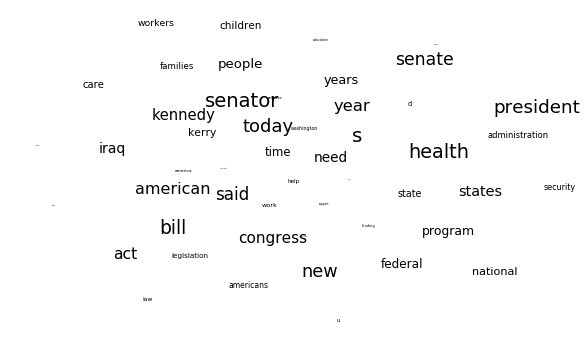

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [19]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [3]:
from ast import literal_eval

In [4]:
def clean_raw_text(raw_texts):
    """
    Clean text documents during pre-processing.
    :param raw_texts: list of raw texts to pre process.
    """

    common_stopwords = ["THE PRESIDENT:", "(Applause.)", "(applause)", "(Laughter.)"]
    stopwords = [x.lower() for x in common_stopwords]
    
    clean_texts = []
    for text in raw_texts:
        try:
            clean_text = text.replace(" \'m", 
                                    "'m").replace(" \'ll", 
                                    "'ll").replace(" \'re", 
                                    "'re").replace(" \'s",
                                    "'s").replace(" \'re", 
                                    "'re").replace(" n\'t", 
                                    "n't").replace(" \'ve", 
                                    "'ve").replace(" /'d", 
                                    "'d").replace('\n','')
            
            clean_text = clean_text.rstrip(" ").rstrip(" ' ").replace("\xa0", "")
            querywords = clean_text.split()
            resultwords  = [word for word in querywords if word.lower() not in stopwords]
            final_text = ' '.join(resultwords)

            clean_texts.append(final_text)
        except AttributeError:
            print("ERROR CLEANING")
            # print(text)
            continue
    return clean_texts

In [5]:
party_affiliation = {"Joe Biden":"Democrat", "Donald Trump": "Republican",
                     "Barack Obama": "Democrat", "George W. Bush": "Republican",
                     "Bill Clinton": "Democrat", "George H. W. Bush": "Republican",
                     "Ronald Reagan": "Republican", "Jimmy Carter": "Democrat",
                     "Gerald Ford": "Republican", "Richard M. Nixon":"Republican",
                     "Lyndon B. Johnson":"Democrat", "John F. Kennedy": "Republican"}

In [ ]:
# speeches = pd.read_excel(r"../data/presidential_speeches_preprocessed.xlsx")
# speeches["normalized_sents"] = speeches.normalized_sents.apply(literal_eval)
speeches = pd.read_excel(r"../data/presidential_speeches.xlsx")
speeches = speeches.drop(columns="Unnamed: 0")
speeches["Speech"] = speeches.Speech.apply(lambda row: clean_raw_text([row])[0])
speeches['tokenized_sents'] = speeches['Speech'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
speeches['normalized_sents'] = speeches['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])
speeches.head()

In [22]:
democrats = speeches.loc[speeches.Party=="Democrat", :]
republicans = speeches.loc[speeches.Party=="Republican", :]

In [ ]:

democratsW2V  = gensim.models.word2vec.Word2Vec(democrats['normalized_sents'].sum())
republicansW2V = gensim.models.word2vec.Word2Vec(republicans['normalized_sents'].sum())

In [46]:
words_of_interest = ["climate", "energy", "environment", "warming",  "fuel",
                     "pollution", "emissions", "clean", "coal", "oil", "gases",
                     "carbon"]

for word in words_of_interest:
    print()
    print(f"Finding words most similar to '{word}' according to its embedding")
    try:
        print("................................................................")
        print("Based on Republican embedding:")
        print(republicansW2V.most_similar(word))
        print()
        print("Based on Democrats embedding:")
        print(democratsW2V.most_similar(word))
        print()
        print()
    except:
        continue


Finding words most similar to 'climate' according to its embedding
................................................................
Based on Republican embedding:
[('reconciliation', 0.9990226030349731), ('reveal', 0.9990065097808838), ('breakthrough', 0.9986928701400757), ('repression', 0.9986748695373535), ('primary', 0.9985640048980713), ('restraint', 0.998558521270752), ('plain', 0.9984785914421082), ('bridge', 0.9984593391418457), ('collapse', 0.9984577298164368), ('resist', 0.9984302520751953)]

Based on Democrats embedding:
[('blow', 0.9979878664016724), ('suffer', 0.9976143836975098), ('ignore', 0.9975333213806152), ('shadow', 0.9973800182342529), ('decay', 0.9972642660140991), ('lesson', 0.9972363710403442), ('crumble', 0.9971195459365845), ('circumstance', 0.9969482421875), ('realize', 0.9968667030334473), ('shatter', 0.9968599081039429)]



Finding words most similar to 'energy' according to its embedding
................................................................
Base

Above, we see the most similar words based on word embeddings on two corpuses (one for democrats, one for republicans) to a set of climate-change related words. 
These embeddings illustrate semantic differences between the use of the same word just based on party affiliation. For example when looking at the closest (smallest cosine distance) words to climate, we see that in the democrat's embedding we have words such as suffer, ignore, decay, lesson and realize, while in the republican embedding we have reconciliation, reveal, breakthrough, repression. These different semantic relationships with the word climate exemplify the connotation that politicans give to it. Another interesting semantic relationship are the closest words to fuel, for democrats these closest words are natural, pollution, modernize, switch, renewable, etc. While those for republicans are completely, gas, significant, overall, target, shipment, etc.

Below we continue this semantic analysis by using the parrallel of analogies based on vector representations of words in embeddings making use of semantic equations.

In [21]:
republicansW2V.most_similar(positive=['renewable', 'oil'], negative = ['clean'])

[('large', 0.9918015003204346),
 ('balance', 0.9883385896682739),
 ('gross', 0.9850810766220093),
 ('massive', 0.9850701093673706),
 ('loan', 0.9845395088195801),
 ('restrain', 0.9826834201812744),
 ('eliminate', 0.9826406240463257),
 ('investment', 0.982413649559021),
 ('food', 0.9823657870292664),
 ('research', 0.9821637272834778)]

In [20]:
democratsW2V.most_similar(positive=['renewable', 'oil'], negative = ['clean'])

[('total', 0.9894525408744812),
 ('surplus', 0.9886621236801147),
 ('approximately', 0.987183153629303),
 ('expenditure', 0.9871408343315125),
 ('crossing', 0.986967146396637),
 ('import', 0.9868594408035278),
 ('collect', 0.9856166839599609),
 ('substantially', 0.9846465587615967),
 ('fiscal', 0.9844328761100769),
 ('revenue', 0.9829734563827515)]

In [32]:
republicanrepublicansW2V.doesnt_match(['clean', 'coal', 'gas', 'renewable', 'fuel'])

'renewable'

In [33]:
republicandemocratsW2V.doesnt_match(['clean', 'coal', 'gas', 'renewable', 'fuel'])

'clean'

By using semantic equations we find a similar result to that found using most similar words, the connotation and relationship among climate and energy 
related words is conditional on party affiliation.

We know change our word2vec parameters to see how semantic assications change. Specifically I change the window which determines the maximum distance between current and predicted words. Note, the default value is window=5, thus the embeddings above are based on that default.

In [ ]:
republicansW2V_window = gensim.models.word2vec.Word2Vec(republicans['normalized_sents'].sum(), window=10)
democratsW2V_window = gensim.models.word2vec.Word2Vec(democrats['normalized_sents'].sum(), window=10)

In [36]:
words_of_interest = ["climate", "energy", "environment", "warming",  "fuel",
                     "pollution", "emissions", "clean", "coal", "oil", "gases",
                     "carbon"]

for word in words_of_interest:
    print()
    print(f"Finding words most similar to '{word}' according to its embedding")
    try:
        print("................................................................")
        print("Based on Republican embedding:")
        print(republicansW2V_window.most_similar(word))
        print()
        print("Based on Democrats embedding:")
        print(democratsW2V_window.most_similar(word))
        print()
        print()
    except:
        continue


Finding words most similar to 'climate' according to its embedding
................................................................
Based on Republican embedding:
[('tie', 0.9980120658874512), ('enter', 0.9975651502609253), ('tolerate', 0.9971322417259216), ('frontier', 0.99689781665802), ('traditional', 0.9968808889389038), ('ruler', 0.9968531727790833), ('yield', 0.9966481924057007), ('starve', 0.9966400861740112), ('ultimately', 0.9966282844543457), ('cultural', 0.9965869784355164)]

Based on Democrats embedding:
[('shadow', 0.9970528483390808), ('planet', 0.996795654296875), ('enhance', 0.9962140321731567), ('scale', 0.9956382513046265), ('seed', 0.9953893423080444), ('ravage', 0.9953389167785645), ('isolation', 0.995337963104248), ('essential', 0.9952484965324402), ('jeopardize', 0.9949911832809448), ('rest', 0.9949898719787598)]



Finding words most similar to 'energy' according to its embedding
................................................................
Based on Republica

The window parameter obviously affects which words are the "closest" to our words of interest, nonethless it is remarkable that
the pattern in which semantic differences arise between the use of the same word just based on party affiliation, seems consistent. For example the word  'fuel'
is related in the democratic embeddings to conservation, natural, pollution, modernize while in the republican's embeddings fuel is closer to gas, equipment, result, amount, decline, etc.

We can now visualize these semantic relationships by using dimensionality reduction to reduce our multi-dimensional spaces into the 2-dim subspace with
the most information and projecting our vector form words onto it.

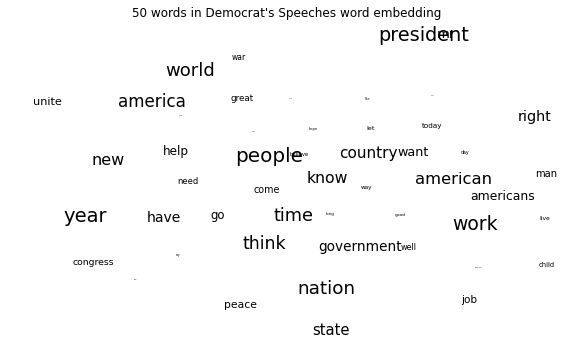

In [38]:
numWords = 50
targetWords = democratsW2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(democratsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.title("50 words in Democrat's Speeches word embedding")
plt.xticks(())
plt.yticks(())
plt.show()

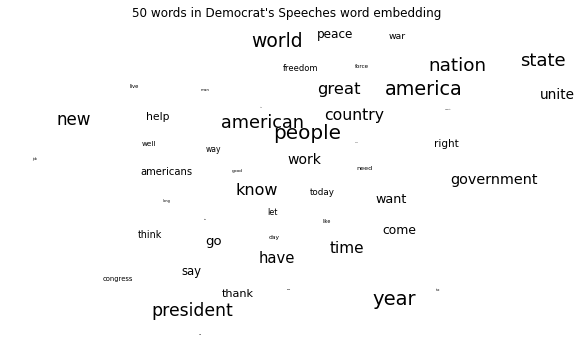

In [39]:
numWords = 50
targetWords = republicansW2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(democratsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.title("50 words in Democrat's Speeches word embedding")
plt.xticks(())
plt.yticks(())
plt.show()


The TSNE representation of each embedding is hard to decipher, from our analysis above it seems looking at the "most similar" words and using semantic equations are the most robust way of understanding different connotations to climate and energy related words across the policial spectrum. The semantic relationship and difference of connotation across party lines seemed consistent in both most similar words and using semantinc analogies.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [8]:
apsDF = pd.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

copyrightYear                        doi  \
0           1950  10.1103/RevModPhys.22.221   
1           1951  10.1103/RevModPhys.23.147   
2           1951  10.1103/RevModPhys.23.185   
3           1951  10.1103/RevModPhys.23.203   
4           1951   10.1103/RevModPhys.23.21   
5           1951  10.1103/RevModPhys.23.311   
6           1951  10.1103/RevModPhys.23.315   
7           1951  10.1103/RevModPhys.23.322   
8           1951  10.1103/RevModPhys.23.328   
9           1952  10.1103/RevModPhys.24.108   

                                            abstract  
0  A summarizing account is given of the research...  
1  New tables of coulomb functions are presented ...  
2  Ionization by electron impact in diatomic gase...  
3  It is shown that the conductivity in the ohmic...  
4  The factorization method is an operational pro...  
5  A brief account is given of Dyson's proof of t...  
6  A systematics is given of all transitions for ...  
7  A systematics of the -transitions of even A nu...  
8  The available experiments on the absorption sp...  
9  The classical theory of the dynamics of viscou...

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [9]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [10]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [11]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [12]:
apsDF.head()

copyrightYear                        doi  \
0           1950  10.1103/RevModPhys.22.221   
1           1951  10.1103/RevModPhys.23.147   
2           1951  10.1103/RevModPhys.23.185   
3           1951  10.1103/RevModPhys.23.203   
4           1951   10.1103/RevModPhys.23.21   

                                            abstract  \
0  A summarizing account is given of the research...   
1  New tables of coulomb functions are presented ...   
2  Ionization by electron impact in diatomic gase...   
3  It is shown that the conductivity in the ohmic...   
4  The factorization method is an operational pro...   

                                     tokenized_words  \
0  [A, summarizing, account, is, given, of, the, ...   
1  [New, tables, of, coulomb, functions, are, pre...   
2  [Ionization, by, electron, impact, in, diatomi...   
3  [It, is, shown, that, the, conductivity, in, t...   
4  [The, factorization, method, is, an, operation...   

                                    normalized_words  \
0  [summarizing, account, given, research, barium...   
1  [new, tables, coulomb, functions, presented, i...   
2  [ionization, electron, impact, diatomic, gases...   
3  [shown, conductivity, ohmic, cuprous, oxide, l...   
4  [factorization, method, operational, procedure...   

                                     TaggedAbstracts  
0  ([summarizing, account, given, research, bariu...  
1  ([new, tables, coulomb, functions, presented, ...  
2  ([ionization, electron, impact, diatomic, gase...  
3  ([shown, conductivity, ohmic, cuprous, oxide, ...  
4  ([factorization, method, operational, procedur...

Now we can train a Doc2Vec model:

In [14]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [15]:
apsD2V.docvecs[1952]

array([ 3.7122926e-01, -6.4646167e-01,  1.6982987e+00,  8.7953544e-01,
       -4.8762110e-01,  1.0780362e+00,  3.8081186e-03,  1.2205195e-03,
        1.0820098e+00, -5.0419736e-01, -4.3222043e-01,  3.2733694e-01,
        2.8410137e-01,  9.4354653e-01, -1.2491578e+00,  1.2921077e+00,
        1.8685295e-01, -1.0378774e+00, -1.9415255e+00,  1.4640850e+00,
        9.3235838e-01, -9.6530163e-01,  4.6398476e-01, -1.5497605e+00,
       -1.3674518e+00, -1.1135633e+00,  1.3536428e+00,  1.6267231e+00,
        7.3703456e-01,  8.0827272e-01, -1.4705558e+00, -1.2174755e+00,
       -1.0194092e+00, -9.5760709e-01,  2.2275592e-01, -1.5621817e-01,
       -1.6570479e+00,  1.0934501e+00,  3.9579701e-01, -7.7281296e-01,
       -1.4904590e-01, -1.2049500e+00,  2.3629843e-01, -6.6289127e-01,
       -4.9041900e-01, -6.9322783e-01,  1.0413918e+00,  1.0654607e+00,
       -2.0093399e-01, -8.3176427e-02, -5.6651419e-01,  1.2510725e+00,
        1.6721536e+00,  1.3840140e+00,  3.8610390e-01,  2.1019322e-01,
      

The words can still be accessed in the same way:

In [16]:
apsD2V['atom']

array([ 0.12017684, -0.928529  ,  0.82052255,  0.5702787 , -0.14521736,
       -0.24899878, -0.7049775 , -0.22399199,  0.6431948 , -0.45931745,
       -0.4150838 ,  0.3186169 ,  0.6368531 ,  0.47637668, -0.5734474 ,
        0.3461148 , -0.83205044,  0.29115683, -0.4976435 , -0.31700808,
        0.23667665,  0.5112749 ,  0.5803003 , -0.93944055, -0.5832798 ,
       -0.07253584, -0.14601775,  0.5913567 , -0.08352218, -0.03377957,
       -0.47562551, -0.4314536 , -0.2508015 ,  0.27502048, -0.15735638,
        0.19524956, -0.38456798, -0.10045854,  0.5200132 ,  0.85781723,
       -0.65343213,  0.15975612, -0.45817378,  0.8273283 ,  0.01188522,
       -0.22157128,  0.74243695,  0.7748708 ,  0.02355322, -0.99609053,
        0.33722997, -0.56609875, -0.10918552,  1.1072267 ,  0.31251827,
        0.7394347 , -1.3492627 , -1.163912  , -0.55275506, -0.78063583,
        0.03376964,  0.41569024,  0.80969155,  0.08873527, -0.7067313 ,
       -0.5054731 ,  0.19938648, -0.1086422 , -1.59292   ,  0.39

We can still use the ``most_similar`` command to perform simple semantic equations:

In [17]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.8368563652038574)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [19]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('arriving', 0.9400806427001953)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [20]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.60702974]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [21]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6250309944152832),
 ('10.1103/PhysRev.113.1545', 0.6036500930786133),
 ('10.1103/PhysRev.110.857', 0.602391242980957),
 ('10.1103/PhysRev.83.1189', 0.6001174449920654),
 ('10.1103/PhysRev.100.1646', 0.5990195274353027)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

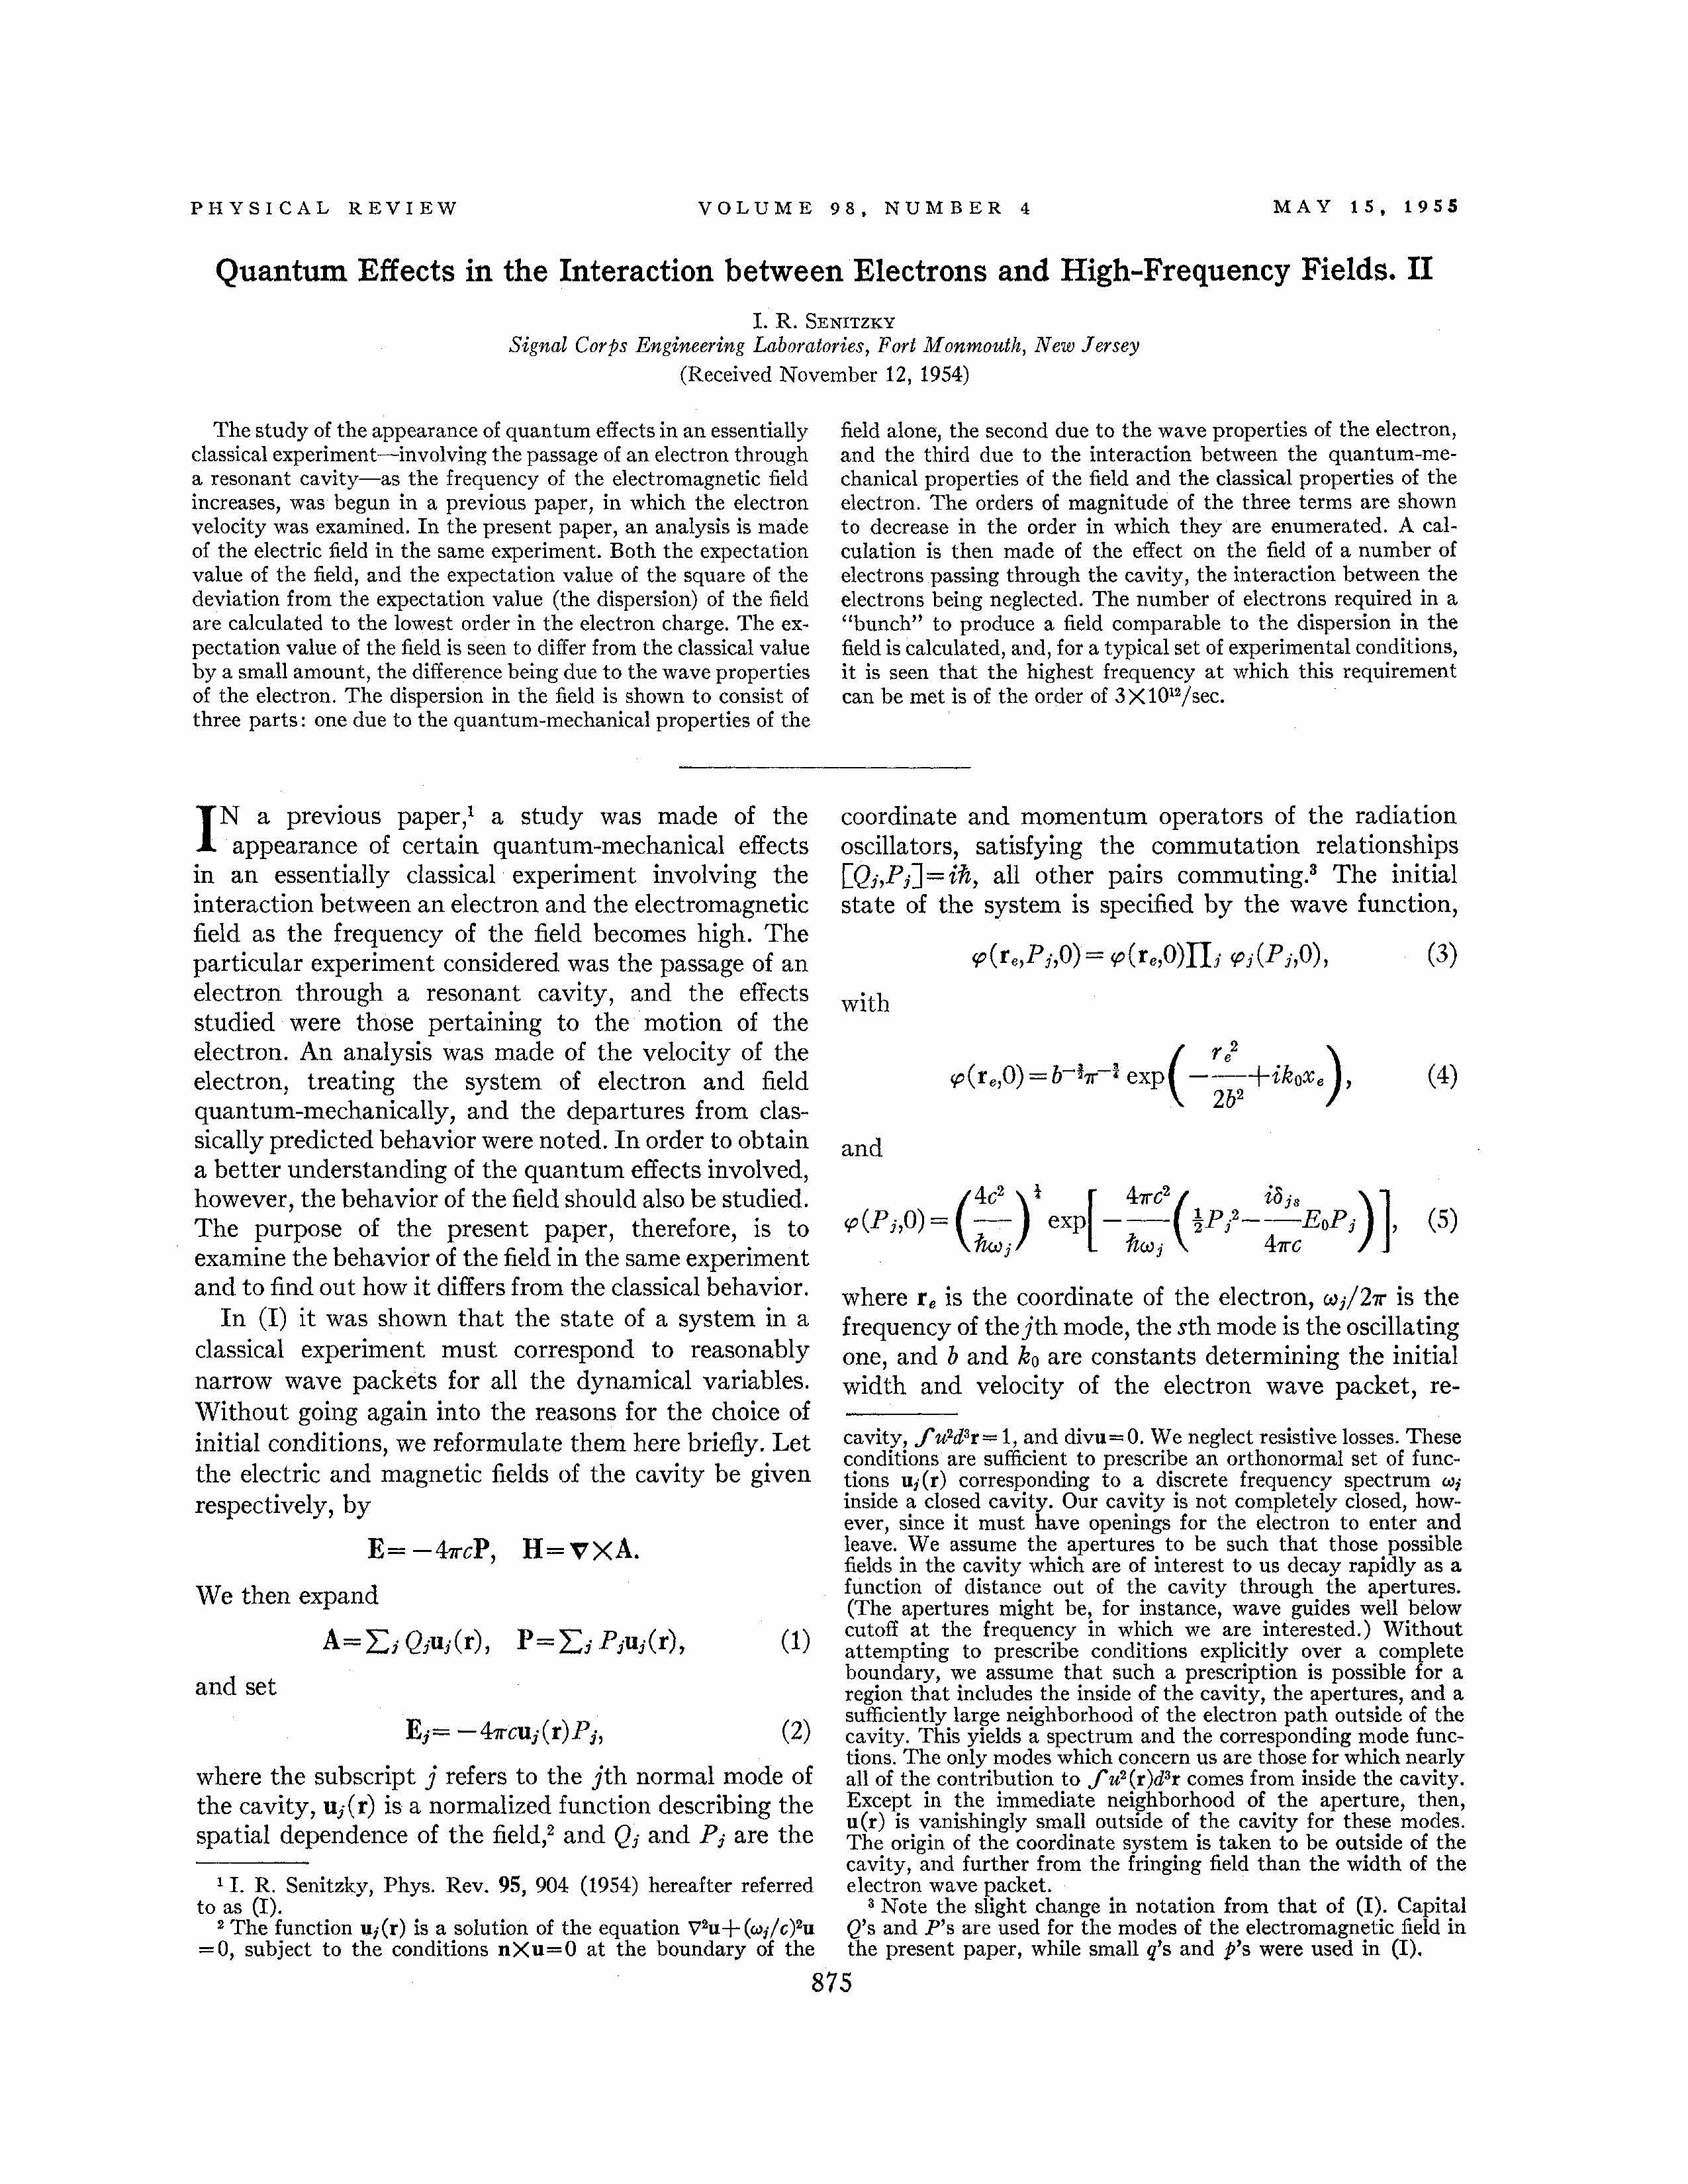

In [36]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [22]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('gyromagnetic', 0.8070497512817383),
 ('ratio', 0.7869307994842529),
 ('attained', 0.7596314549446106),
 ('emu', 0.7356574535369873),
 ('greater', 0.7345484495162964)]

We can even look for documents most like a query composed of multiple words:

In [23]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7259756922721863),
 ('10.1103/PhysRev.101.247', 0.7248409986495972),
 ('10.1103/PhysRev.105.1665', 0.7093296051025391),
 ('10.1103/PhysRev.103.966', 0.7023868560791016),
 ('10.1103/PhysRev.96.1554', 0.6929352879524231)]

Now let's plot some words and documents against one another with a heatmap:

In [24]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

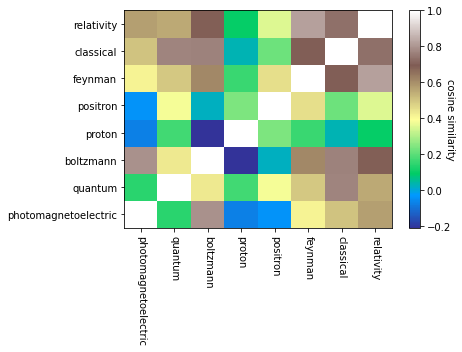

In [25]:
speechesD2Vfig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [26]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

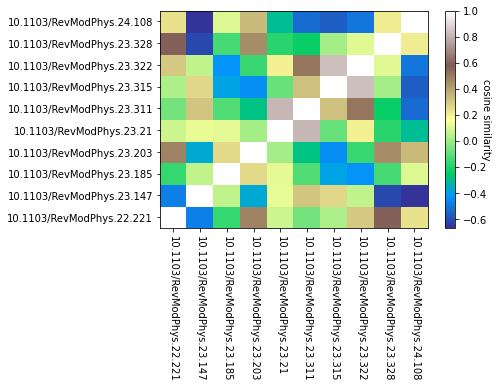

In [27]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [28]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

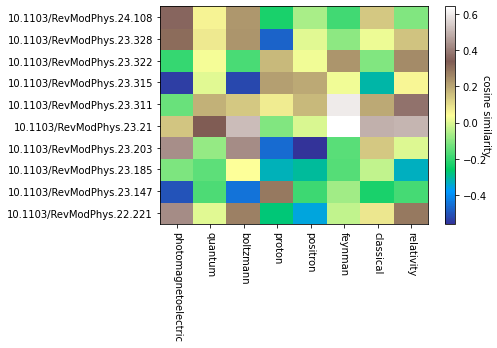

In [29]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [45]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [38]:
speeches = pd.read_excel(r"../data/presidential_speeches_preprocessed.xlsx")
speeches["normalized_sents"] = speeches.normalized_sents.apply(literal_eval)
speeches = speeches.drop(columns="Unnamed: 0")
speeches.head()

President              Date  \
0     Joe Biden  January 20, 2021   
1  Donald Trump  January 19, 2021   
2  Donald Trump  January 13, 2021   
3  Donald Trump  January 07, 2021   
4  Donald Trump  January 06, 2021   

                                              Speech  \
0  Chief Justice Roberts, Vice President Harris, ...   
1  My fellow Americans: Four years ago, we launch...   
2  My fellow Americans,I want to speak to you ton...   
3  I would like to begin by addressing the heinou...   
4  I know your pain. I know your hurt.We had an e...   

                                     tokenized_sents  \
0  [['Chief', 'Justice', 'Roberts', 'Vice', 'Pres...   
1  [['My', 'fellow', 'Americans', 'Four', 'years'...   
2  [['My', 'fellow', 'Americans', 'I', 'want', 't...   
3  [['I', 'would', 'like', 'to', 'begin', 'by', '...   
4  [['I', 'know', 'your', 'pain'], ['I', 'know', ...   

                                    normalized_sents       Party  
0  [[chief, justice, roberts, vice, president, ha...    Democrat  
1  [[fellow, americans, year, ago, launch, great,...  Republican  
2  [[fellow, americans, want, speak, tonight, tro...  Republican  
3  [[like, begin, address, heinous, attack, unite...  Republican  
4  [[know, pain], [know, hurt], [election, steal]...  Republican

In [42]:
speeches['tokenized_words'] = speeches['Speech'].apply(lambda x: lucem_illud.word_tokenize(x))
speeches['normalized_words'] = speeches['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [46]:
keywords = ["climate", "energy", "environment", "warming",  "fuel",
            "pollution", "emissions", "clean", "coal", "oil", "gases","carbon"]

In [42]:
documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(speeches.normalized_words.values)]
speechesD2V = gensim.models.doc2vec.Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [61]:
# For each keyword find the most similar speech and print the president and date of the speech

for word in keywords:
    similar = speechesD2V.docvecs.most_similar([ speechesD2V[word] ], topn=3)
    idxs =[num for num, sim in similar]
    print(f"""The 3 most similar speeches to the word " {word} " where given by {speeches.iloc[idxs,0].values} \non the dates {speeches.iloc[idxs,1].values} """)
    print()


The 3 most similar speeches to the word " climate " where given by ['Lyndon B. Johnson' 'Ronald Reagan' 'Ronald Reagan'] 
on the dates ['July 01, 1968' 'November 18, 1981' 'June 17, 1982'] 

The 3 most similar speeches to the word " energy " where given by ['Barack Obama' 'Ronald Reagan' 'Barack Obama'] 
on the dates ['February 13, 2013' 'January 25, 1983' 'January 20, 2015'] 

The 3 most similar speeches to the word " environment " where given by ['Lyndon B. Johnson' 'Barack Obama' 'Barack Obama'] 
on the dates ['January 04, 1965' 'February 13, 2013' 'January 20, 2015'] 

The 3 most similar speeches to the word " warming " where given by ['George W. Bush' 'Lyndon B. Johnson' 'George W. Bush'] 
on the dates ['January 31, 2006' 'January 04, 1965' 'January 28, 2008'] 

The 3 most similar speeches to the word " fuel " where given by ['Gerald Ford' 'Jimmy Carter' 'Barack Obama'] 
on the dates ['January 15, 1975' 'April 18, 1977' 'February 13, 2013'] 

The 3 most similar speeches to the wor

Above we use document embeddings to find which speeches by which president are the most similar (based on cosine distance) to
our words of interest. Some interest patterns here are the fact that the three most similar speeches to the word "oil" where all
given by Barack Obama. Furthermore, the most similar speeches to the word "carbon" where all by Democratic presidents (Obama and Clinton)
below we explore some spefic speeches from the above.

In [71]:
carbon_idx = speechesD2V.docvecs.most_similar([ speechesD2V["oil"] ], topn=2)[0][0]
speeches.iloc[carbon_idx,2][:15000]

"Mr. Speaker, Mr. Vice President, members of Congress, fellow citizens: Fifty-one years ago, John F. Kennedy declared to this chamber that “the Constitution makes us not rivals for power but partners for progress.” “It is my task,” he said, “to report the State of the Union -- to improve it is the task of us all.” Tonight, thanks to the grit and determination of the American people, there is much progress to report. After a decade of grinding war, our brave men and women in uniform are coming home. After years of grueling recession, our businesses have created over six million new jobs. We buy more American cars than we have in five years, and less foreign oil than we have in 20. Our housing market is healing, our stock market is rebounding, and consumers, patients, and homeowners enjoy stronger protections than ever before. So, together, we have cleared away the rubble of crisis, and we can say with renewed confidence that the State of our Union is stronger. But we gather here knowing

A small important snipet of the above text:

"Today, no area holds more promise than our investments in American energy. After years of talking about it, we’re finally poised to control our own energy future. We produce more oil at home than we have in 15 years. We have doubled the distance our cars will go on a gallon of gas, and the amount of renewable energy we generate from sources like wind and solar -- with tens of thousands of good American jobs to show for it. We produce more natural gas than ever before -- and nearly everyone’s energy bill is lower because of it. And over the last four years, our emissions of the dangerous carbon pollution that threatens our planet have actually fallen. But for the sake of our children and our future, we must do more to combat climate change. Now, it’s true that no single event makes a trend. But the fact is the 12 hottest years on record have all come in the last 15. Heat waves, droughts, wildfires, floods -- all are now more frequent and more intense. We can choose to believe that Superstorm Sandy, and the most severe drought in decades, and the worst wildfires some states have ever seen were all just a freak coincidence. Or we can choose to believe in the overwhelming judgment of science -- and act before it’s too late. Now, the good news is we can make meaningful progress on this issue while driving strong economic growth. I urge this Congress to get together, pursue a bipartisan, market-based solution to climate change, like the one John McCain and Joe Lieberman worked on together a few years ago. But if Congress won’t act soon to protect future generations, I will. I will direct my Cabinet to come up with executive actions we can take, now and in the future, to reduce pollution, prepare our communities for the consequences of climate change, and speed the transition to more sustainable sources of energy. Four years ago, other countries dominated the clean energy market and the jobs that came with it. And we’ve begun to change that. Last year, wind energy added nearly half of all new power capacity in America. So let’s generate even more. Solar energy gets cheaper by the year -- let’s drive down costs even further. As long as countries like China keep going all in on clean energy, so must we. Now, in the meantime, the natural gas boom has led to cleaner power and greater energy independence. We need to encourage that. And that’s why my administration will keep cutting red tape and speeding up new oil and gas permits. "

It is very clear that this specific speech by Obama was related to clean energy and renewables.

In [82]:
speechesD2V.most_similar(positive=['renewable', 'oil'], negative = ['clean'])

[('firepower', 0.9916403293609619),
 ('ducey', 0.9910129308700562),
 ('jeb', 0.9898567199707031),
 ('rug', 0.9884160757064819),
 ('sharpest', 0.9884011149406433),
 ('chicano', 0.9883087277412415),
 ('thes', 0.9873701930046082),
 ('legs', 0.9841946959495544),
 ('output', 0.9839418530464172),
 ('power?the', 0.9837002158164978)]

In [83]:
speechesD2V.doesnt_match(['clean', 'coal', 'gas', 'renewable', 'fuel'])

'renewable'

In [94]:
speechesD2V["clean"]

array([ 1.6568015 , -1.0600026 ,  2.023948  ,  0.18505189,  0.5702159 ],
      dtype=float32)

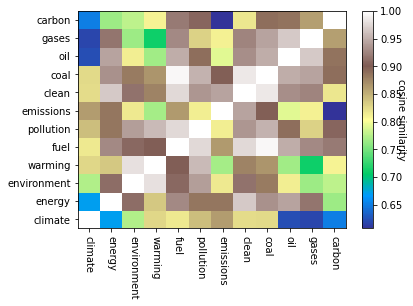

In [95]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = speechesD2V[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, speechesD2V[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [7]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [8]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [9]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

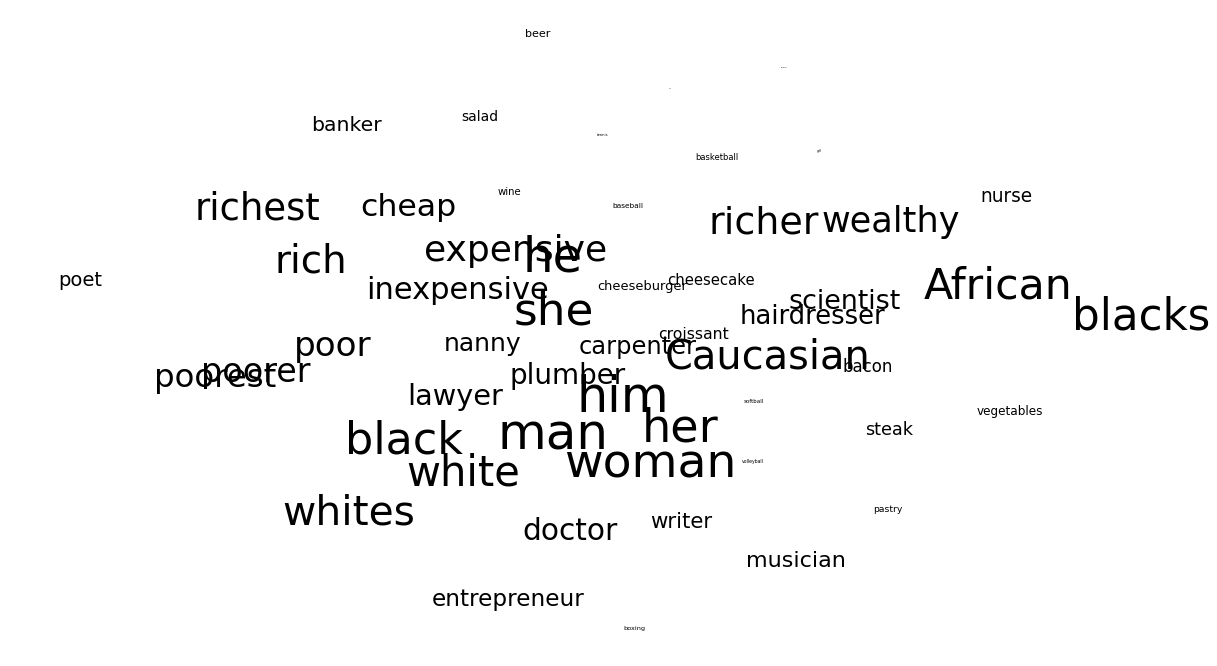

In [10]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [11]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [12]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [13]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [62]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [63]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [92]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.copper(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

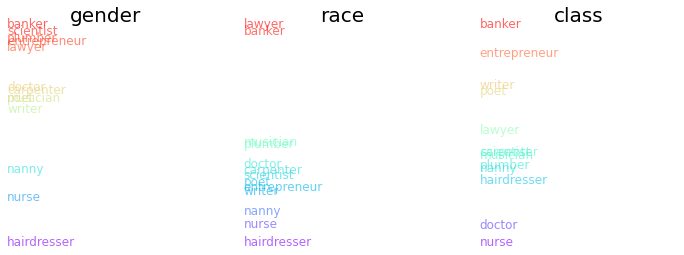

In [17]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

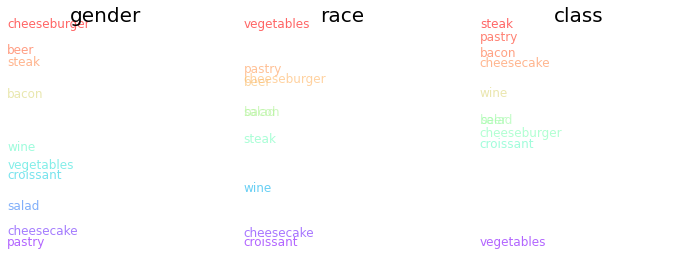

In [18]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

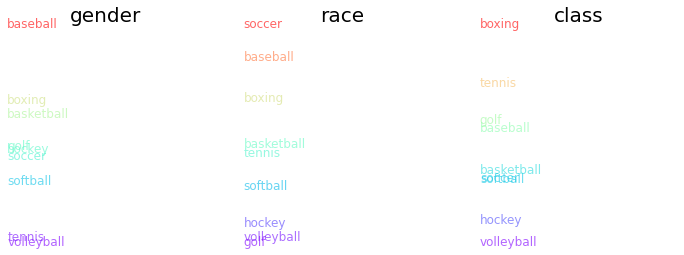

In [19]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [20]:
speeches.head()

Unnamed: 0     President              Date  \
0           0     Joe Biden  January 20, 2021   
1           1  Donald Trump  January 19, 2021   
2           2  Donald Trump  January 13, 2021   
3           3  Donald Trump  January 07, 2021   
4           4  Donald Trump  January 06, 2021   

                                              Speech  \
0  Chief Justice Roberts, Vice President Harris, ...   
1  My fellow Americans: Four years ago, we launch...   
2  My fellow Americans,I want to speak to you ton...   
3  I would like to begin by addressing the heinou...   
4  I know your pain. I know your hurt.We had an e...   

                                     tokenized_sents  \
0  [['Chief', 'Justice', 'Roberts', 'Vice', 'Pres...   
1  [['My', 'fellow', 'Americans', 'Four', 'years'...   
2  [['My', 'fellow', 'Americans', 'I', 'want', 't...   
3  [['I', 'would', 'like', 'to', 'begin', 'by', '...   
4  [['I', 'know', 'your', 'pain'], ['I', 'know', ...   

                                    normalized_sents       Party  
0  [[chief, justice, roberts, vice, president, ha...    Democrat  
1  [[fellow, americans, year, ago, launch, great,...  Republican  
2  [[fellow, americans, want, speak, tonight, tro...  Republican  
3  [[like, begin, address, heinous, attack, unite...  Republican  
4  [[know, pain], [know, hurt], [election, steal]...  Republican

In [ ]:
democratsW2V  = gensim.models.word2vec.Word2Vec(democrats['normalized_sents'].sum())
republicansW2V = gensim.models.word2vec.Word2Vec(republicans['normalized_sents'].sum())
speechesW2V = gensim.models.word2vec.Word2Vec(speeches['normalized_sents'].sum())

In [81]:
#words to create dimensions
TargetWords = ["climate", "energy", "environment", "fuel","pollution", "capitalism", "regulation","welfare","military",'poor', 'immigration', 'education',
               'ally', 'religion', 'catholic', 'democrat', 'republican']
#words we will be mapping

wordsSubMatrixSpeeches = []
for word in TargetWords:
    wordsSubMatrixSpeeches.append(speechesW2V[word])
wordsSubMatrixSpeeches = np.array(wordsSubMatrixSpeeches)
#wordsSubMatrix

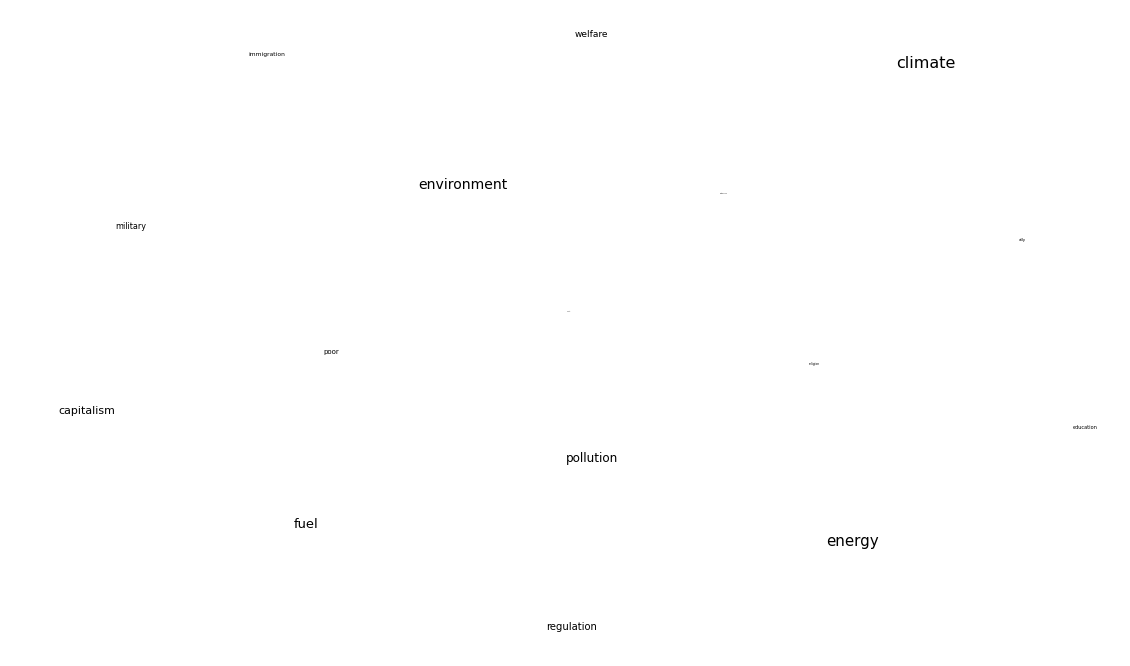

In [61]:
pcaWords = sklearn.decomposition.PCA(n_components = len(TargetWords)).fit(wordsSubMatrixSpeeches)
reducedPCA_data = pcaWords.transform(wordsSubMatrixSpeeches)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(TargetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  len(TargetWords) * (len(TargetWords) - i) / len(TargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

## Check what are the most used words by each party

In [46]:
# check what are the most used words by each party
from spacy.lang.en.stop_words import STOP_WORDS
def wordCounter(wordLst):
    """
    Update wordCounter function to avoid counting stopwords.
    :param wordList: list of str words
    """
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in STOP_WORDS:
            continue
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)

    result = pandas.DataFrame(countsForFrame)
    result.sort_values('count', ascending=False, inplace=True)

    return result

In [44]:
speeches.head()

Unnamed: 0     President              Date  \
0           0     Joe Biden  January 20, 2021   
1           1  Donald Trump  January 19, 2021   
2           2  Donald Trump  January 13, 2021   
3           3  Donald Trump  January 07, 2021   
4           4  Donald Trump  January 06, 2021   

                                              Speech  \
0  Chief Justice Roberts, Vice President Harris, ...   
1  My fellow Americans: Four years ago, we launch...   
2  My fellow Americans,I want to speak to you ton...   
3  I would like to begin by addressing the heinou...   
4  I know your pain. I know your hurt.We had an e...   

                                     tokenized_sents  \
0  [['Chief', 'Justice', 'Roberts', 'Vice', 'Pres...   
1  [['My', 'fellow', 'Americans', 'Four', 'years'...   
2  [['My', 'fellow', 'Americans', 'I', 'want', 't...   
3  [['I', 'would', 'like', 'to', 'begin', 'by', '...   
4  [['I', 'know', 'your', 'pain'], ['I', 'know', ...   

                                    normalized_sents       Party  \
0  [[chief, justice, roberts, vice, president, ha...    Democrat   
1  [[fellow, americans, year, ago, launch, great,...  Republican   
2  [[fellow, americans, want, speak, tonight, tro...  Republican   
3  [[like, begin, address, heinous, attack, unite...  Republican   
4  [[know, pain], [know, hurt], [election, steal]...  Republican   

                                     tokenized_words  \
0  [Chief, Justice, Roberts, Vice, President, Har...   
1  [My, fellow, Americans, Four, years, ago, we, ...   
2  [My, fellow, Americans, I, want, to, speak, to...   
3  [I, would, like, to, begin, by, addressing, th...   
4  [I, know, your, pain, I, know, your, hurt, We,...   

                                    normalized_words  
0  [chief, justice, roberts, vice, president, har...  
1  [fellow, americans, years, ago, launched, grea...  
2  [fellow, americans, want, speak, tonight, trou...  
3  [like, begin, addressing, heinous, attack, uni...  
4  [know, pain, know, hurt, election, stolen, lan...

In [50]:
print("Most used words by republicans")
wordCounter(speeches.loc[speeches.Party=="Republican", "tokenized_words"].sum())[:20]

Most used words by republicans


word  count
52        people   2835
19       america   2021
79         world   1929
125     american   1625
33           new   1560
23     president   1543
2          years   1278
24        united   1272
14    government   1271
312         time   1267
735         know   1259
25        states   1258
5          great   1188
9        country   1165
136        peace   1112
133       nation   1060
43          want   1028
1002       going    939
1      americans    922
82         thank    870

In [49]:
print("Most used words by democrats")
wordCounter(speeches.loc[speeches.Party=="Democrat", "tokenized_words"].sum())[:20]

Most used words by democrats


word  count
34        people   2865
4      president   2066
129        world   1517
16       america   1473
64      american   1455
170          new   1370
377        think   1289
139        years   1282
282         time   1269
125      country   1091
201         work   1090
71          know   1082
15     americans   1023
943   government   1017
53        nation    985
127         year    981
103        peace    975
276       united    949
2156         mr.    939
626     congress    925

It seems the most used words overlap a lot for both party's so using those words for semantic dimensions might not be very insightful.

In [ ]:
TargetWords

In [78]:
# create two semantic dimensions
party = dimension(speechesW2V, ["republican"], ["democrat"])
ideology = dimension(speechesW2V, ['liberal'], ['conservative'])

In [82]:
def makeDF(model, word_list, dimensions):
    """
    Function to create datframe with semantic dimentions
    :param model: word2vec model
    :param word_list: words to project into dimensions
    :param dimensions: list of arrays of word embedding
    """
    result_dict = {'dim'+str(i+1):[] for i in range(len(dimensions))}

    for word in word_list:
        for i, dim in enumerate(result_dict.keys()):
            result_dict[dim].append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dimensions[i].reshape(1,-1))[0][0])

    df = pandas.DataFrame(result_dict, index = word_list)
    return df

In [83]:
projDF=makeDF(speechesW2V, TargetWords, [party, ideology])
projDF.columns = ["party", "ideology"]

In [76]:
projDF.loc[:,"party"]

climate        0.119666
energy        -0.118046
environment   -0.237701
fuel          -0.170503
pollution     -0.047239
capitalism    -0.006486
regulation    -0.321465
welfare       -0.535323
military       0.368526
poor          -0.530278
immigration   -0.303260
education     -0.517494
ally           0.544693
religion       0.136668
catholic       0.032971
Name: party, dtype: float64

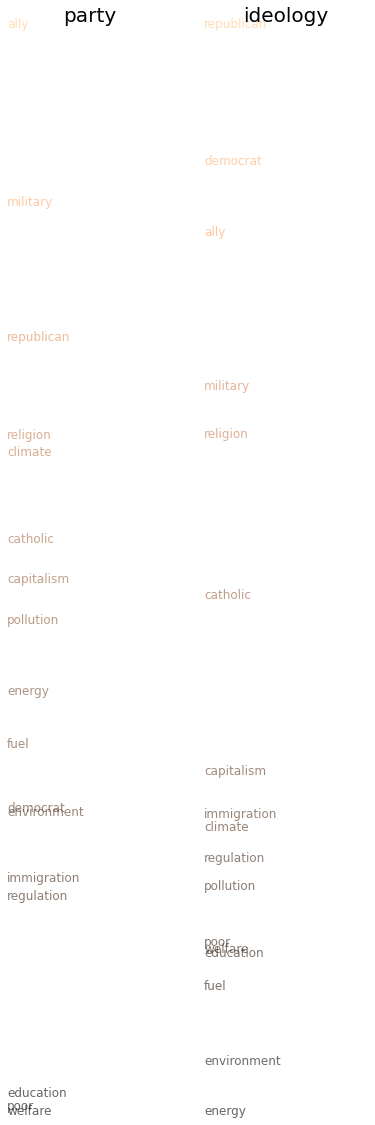

In [93]:
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, projDF, 'party')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, projDF, 'ideology')
plt.show()

In the above figure we see the plot of our words of interest when projecting them into two dimensions: one for party affiliation and one for ideology. 
Although this is a coarse analysis, it seems the party affiliation dimension captures more of the variation in the projection of our words of interest. 
Words like education, poor, welfare, immigration appear to be closer to the democratic pole of the party dimension while
words such as military, capitalism and religion gravitate more towards the religion side.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [60]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Unnamed: 0 hiringOrganization_organizationName  \
0       158844       Golfsmith International, Inc.   
1       257645                               Intel   
2       107875                    Florida Hospital   
3       202394                Hitachi Data Systems   
4       109675           Footprint Retail Services   
5       215973                          Home Depot   
6       207524                          Home Depot   
7        64426                      East West Bank   
8       245192                                 IBM   
9       202429                Hitachi Data Systems   
10      269503             J&J Family of Companies   
11      139164                  Genesis Healthcare   
12      255915                      Ingersoll Rand   
13      173294         HamiltonConstructionCompany   
14      116855                      G6 Hospitality   
15       40701                         Dollar Tree   
16      292406              Johns Hopkins Medicine   
17      358904                           LHC Group   
18      126507                                  GE   
19       90538                                  EY   
20       59256             Dr Pepper Snapple Group   
21       85716     Eurofins Lancaster Laboratories   
22      203342                             HMSHOST   
23      283327                          Jewel-Osco   
24      320876       KeyPoint Government Solutions   
25      311069                      Kelly Services   
26      141835              Genesis Rehabilitation   
27      202406                Hitachi Data Systems   
28      111597     Franciscan St. Eilzabeth Health   
29      260448                               Intel   
..         ...                                 ...   
70      197429                            Hill-Rom   
71      359233                           LHC Group   
72        5520                     DCS Corporation   
73      205825                          Home Depot   
74       68546    Education Corporation of America   
75      141067              Genesis Rehabilitation   
76       26925        Destination Hotels & Resorts   
77       81637                Epic Health Services   
78      191317  Hewlett Packard Enterprise Company   
79      134395                  Genesis Healthcare   
80      177803                  Harris Corporation   
81      222835                          Home Depot   
82       12790                            Deloitte   
83      319987            Kettering Medical Center   
84      352211                 Learning Care Group   
85      233278                              Humana   
86      338881                 Kronos Incorporated   
87       53773                       Dominos Pizza   
88      158203                       Golden Living   
89      156994                       Golden Living   
90      249542                   ICF International   
91      173219                     Hallmark Health   
92       50969                       Dominos Pizza   
93      331404                              Kforce   
94      322250                              Kforce   
95      157791                       Golden Living   
96      119835                            GameStop   
97      285609                          Jewel-Osco   
98       89260                     Express Scripts   
99      280096                            JCPenney   

                                       jobDescription  \
0   "Sales Associate Tracking Code 220425-971 Job ...   
1   For PHY system engineering team within the Wir...   
2   *RN Medical Oncology PCU Orlando - Nights* Flo...   
3   Title: Specialist Sales Account Representative...   
4   **Footprint Retail Services** **Job Descriptio...   
5   Position Purpose: Provide outstanding service ...   
6   The Asset Protection Specialist is primarily r...   
7   # Job Description East West Bank is one of the...   
8   Job Description IBM is seeking to hire a Senio...   
9   Title: Field Solutions Engineer Location: New ...   
10  Project Manager (m/w) - 

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [63]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

likelihood
hiringOrganization_organizationName             
Honeywell                             -25.974749
Legrand North America                 -40.500500
Franciscan St. Eilzabeth Health       -43.167206
Illinois Wesleyan University          -52.681591
Gold's Gym                            -75.230896
Jewel-Osco                            -80.965462
Ingersoll Rand                        -81.494949
Kaiser Permanente                     -85.523113
Hallmark Health                       -86.037094
Dr Pepper Snapple Group               -99.421326
General Dynamics Mission Systems     -101.916016
Emory Healthcare                     -102.271820
Genesis Rehabilitation               -105.064774
EY                                   -105.651237
Hewlett Packard Enterprise Company   -106.875103
Dominos Pizza                        -116.374700
Intel                                -117.038742
East West Bank                       -119.060699
DCS Corporation                      -119.501137
Ken Garff                            -120.361084
EMC                                  -121.622444
Eurofins Lancaster Laboratories      -122.223595
Kettering Medical Center             -122.765350
Kronos Incorporated                  -122.840622
HCR ManorCare                        -123.508369
Golfsmith International, Inc.        -123.573792
Kelly Services                       -130.990227
IBM                                  -131.666611
Harris Corporation                   -131.853256
Deutsche Bank                        -132.499237
...                                          ...
Laboratory Corporation of America    -145.438156
Education Corporation of America     -146.955536
KPMG                                 -148.719376
Kelle's Transport Service Inc        -159.437958
Florida Hospital                     -162.604172
Learning Care Group                  -167.503754
J&J Family of Companies              -168.375862
ICF International                    -168.376930
GE                                   -169.097389
Humana                               -172.795746
Footprint Retail Services            -174.338989
Express Scripts                      -177.804581
Deloitte                             -183.557471
Golden Living                        -192.657858
Eaton Corporation                    -209.906540
GPC - Genuine Parts Company          -212.211792
JPMorgan Chase                       -228.657028
Hitachi Data Systems                 -229.553279
Destination Hotels & Resorts         -263.172791
HamiltonConstructionCompany          -324.117249
GameStop                             -328.072083
La Quinta Inns & Suites              -343.545471
Home Depot                           -357.972627
HMSHOST                              -409.498688
LHC Group                            -413.633423
G6 Hospitality                       -468.546722
Epic Health Services                 -527.781067
Kforce                               -762.142422
Dollar Tree                          -818.945801
Hill-Rom                            -2675.631592

[67 rows x 1 columns]

We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

likelihood
jobLocation_address_region             
Utah                         -40.500500
Montana                      -63.730721
Connecticut                  -67.623466
Kansas                       -85.259682
Tennessee                    -93.188822
Illinois                     -93.989101
New Hampshire                -94.109772
Georgia                     -102.271820
South Carolina              -103.527328
North Carolina              -108.747134
Ohio                        -122.494473
Louisiana                   -138.063202
Florida                     -147.725601
California                  -147.850291
Maryland                    -151.947347
Arizona                     -154.733734
Minnesota                   -159.437958
Virginia                    -160.932640
Wisconsin                   -170.760437
Missouri                    -177.804581
South Dakota                -180.824776
Nebraska                    -194.792297
Kentucky                    -200.726387
Massachusetts               -205.022661
Oklahoma                    -209.906540
Pennsylvania                -219.999863
New Jersey                  -237.326090
Alabama                     -320.879336
New York                    -328.072083
Indiana                     -328.259613
Texas                       -349.076205
New Mexico                  -447.911438
Oregon                      -453.519656
Michigan                   -1449.594093

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [94]:
ascoDF

Year                                   AbstractCategory  \
0      1995                                        Lung Cancer   
1      1995                                      Breast Cancer   
2      1995                                 Gynecologic Cancer   
3      1995                                        Lung Cancer   
4      1995                      Other Gastrointestinal Cancer   
5      1995                                      Breast Cancer   
6      1995                               Genitourinary Cancer   
7      1995      Preclinical Experimental Therapeutics - Other   
8      1995                                      Tumor Biology   
9      1995  Developmental TherapeuticsÑClinical Pharmacolo...   
10     1995  Hematologic MalignanciesÑLymphoma and Chronic ...   
11     1995  Hematologic MalignanciesÑLymphoma and Chronic ...   
12     1995                                      Breast Cancer   
13     1995  Hematologic MalignanciesÑLeukemia, Myelodyspla...   
14     1995  Hematologic MalignanciesÑLeukemia, Myelodyspla...   
15     1995  Developmental TherapeuticsÑClinical Pharmacolo...   
16     1995                                      Breast Cancer   
17     1995                                      Breast Cancer   
18     1995                      Central Nervous System Tumors   
19     1995                      Other Gastrointestinal Cancer   
20     1995  Developmental TherapeuticsÑClinical Pharmacolo...   
21     1995                      Other Gastrointestinal Cancer   
22     1995                                      Breast Cancer   
23     1995                                      Breast Cancer   
24     1995  Developmental TherapeuticsÑClinical Pharmacolo...   
25     1995                                            Sarcoma   
26     1995                                      Breast Cancer   
27     1995  Developmental TherapeuticsÑClinical Pharmacolo...   
28     1995                     Psychosocial Aspects of Cancer   
29     1995                               Health Care Research   
...     ...                                                ...   
62348  2011               Gastrointestinal (Colorectal) Cancer   
62351  2011                           Health Services Research   
62361  2011                          Patient and Survivor Care   
62362  2011  Developmental TherapeuticsÑClinical Pharmacolo...   
62371  2011  Hematologic MalignanciesÑLeukemia, Myelodyspla...   
62386  2011  Breast CancerÑTriple-Negative/Cytotoxics/Local...   
62396  2011               Gastrointestinal (Colorectal) Cancer   
62402  2011  Developmental TherapeuticsÑClinical Pharmacolo...   
62407  2011  Hematologic MalignanciesÑLymphoma and Chronic ...   
62414  2011                               Genitourinary Cancer   
62431  2011                     Cancer Prevention/Epidemiology   
62452  2011                     Cancer Prevention/Epidemiology   
62456  2011                              Melanoma/Skin Cancers   
62462  2011                           Health Services Research   
62467  2011                      Central Nervous System Tumors   
62484  2011                      Central Nervous System Tumors   
62503  2011                           Health Services Research   
62512  2011                           Health Services Research   
62515  2011  Developmental TherapeuticsÑExperimental Therap...   
62541  2011                           Health Services Research   
62543  2011                          Patient and Survivor Care   
62544  2011                                      Tumor Biology   
62551  2011                           Health Services Research   
62561  2011  Developmental TherapeuticsÑExperimental Therap...   
62564  2011                                 Pediatric Oncology   
62568  2011  Lung Cancer - Local-Regional and Adjuvant Ther...   
62576  2011                          Patient and Survivor Care   
62577  2011  Developmental TherapeuticsÑExperimental Therap...   
62585  2011                               Genit

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [183]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [184]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [95]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


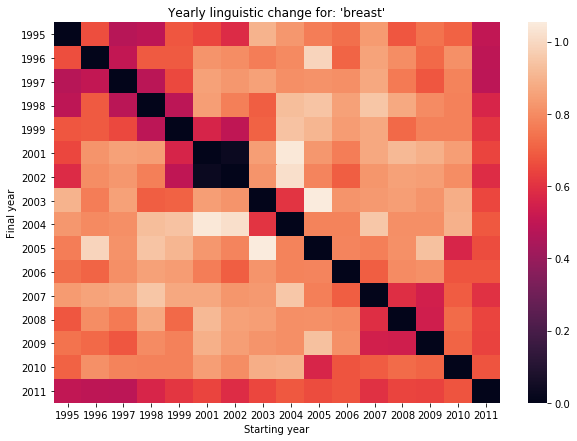

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


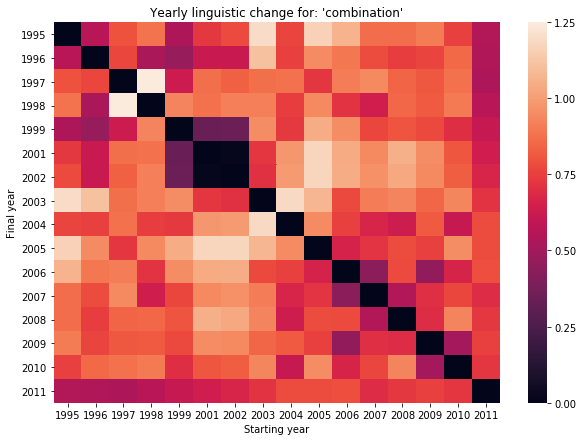

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


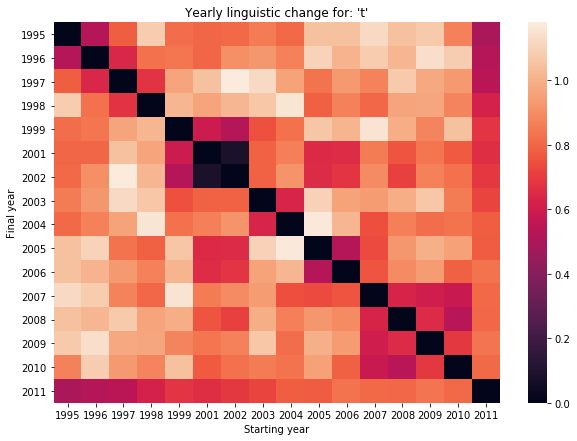

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


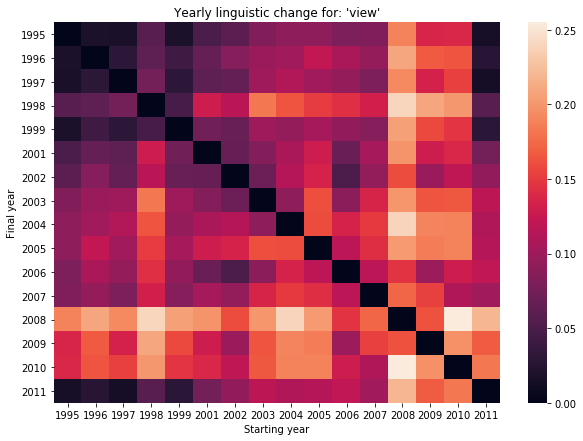

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [88]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [89]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [114]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [115]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud_2020.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [176]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [178]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [179]:
from gensim.models import Word2Vec

In [191]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [192]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [193]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [194]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [195]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 